# Solution Approach

For this task of recognizing simple captchas, we only have very few examples for each possible character, but the inputs/outputs are extremely constrained and well-structured. In particular, the signal can be easily extracted from the noisy input.

This calls for an approach where the human expert injects as much prior knowledge as possible (via handcrafted feature extraction) since the sample size simply does not support any sample-heavy learning.

We first test a few conjectures regarding the well-formed-ness of the inputs and employ an instance-based approach -- nearest-neighbors in this case. This quick-and-dirty approach can tolerate minor changes with some extra work (e.g. segmentation) but is definitely not robust enough to withstand any significant violation of the assumptions.

# We shall quickly test a few conjectures...

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

(30, 60, 3)
(30, 60, 3)
(30, 60, 3)


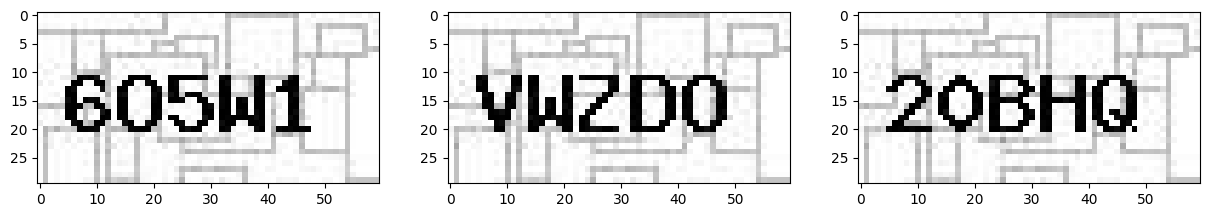

In [2]:
inputs=[np.array(Image.open('input/input{:02}.jpg'.format(i))) for i in [2,13,17]]  #read 3 random inputs

plt.figure(figsize=(15,3))
for i,im in enumerate(inputs):
    plt.subplot(1,3,i+1)
    plt.imshow(im)
    print(im.shape)

## 1. "Eyeballing" a few random examples suggests that the images are all grayscale and the Captcha characters stand out against the background as extra dark pixels

In [3]:
## check whether there is any RGB channel difference
for im in inputs:
    assert (im[:,:,0]==im[:,:,1]).all() and (im[:,:,0]==im[:,:,2]).all()

**No RGB channel difference, we can simply take the first channel**

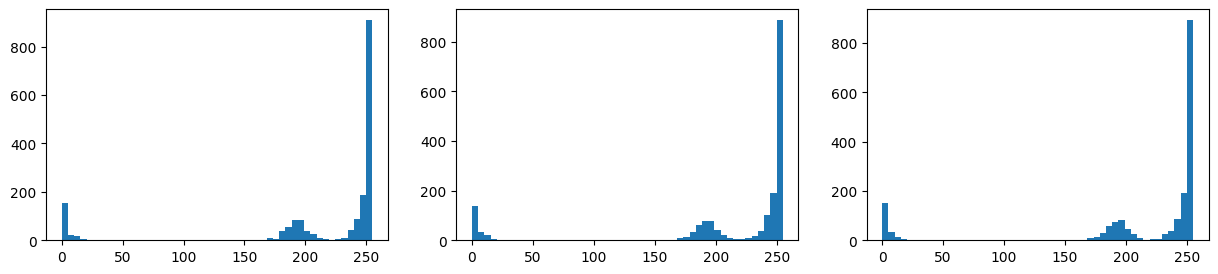

In [4]:
plt.figure(figsize=(15,3))
for i,im in enumerate(inputs):
    plt.subplot(1,3,i+1)
    _=plt.hist(im[:,:,0].flatten(),50)

**Pixel value histograms clearly show 3 brightness groups -- the signal obviously is in the darkest group. A brightness cutoff point around 100 seems rather robust**

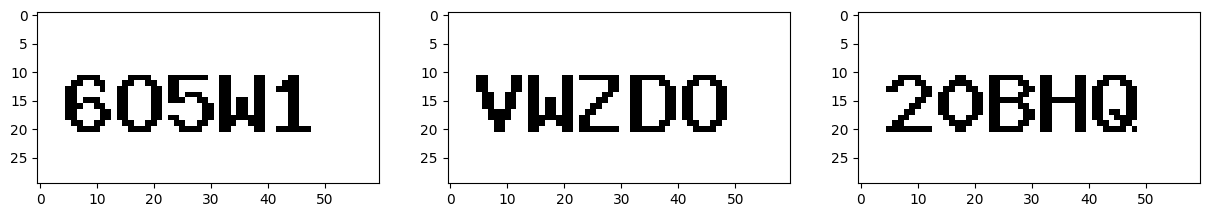

In [5]:
plt.figure(figsize=(15,3))
for i,im in enumerate(inputs):
    plt.subplot(1,3,i+1)
    plt.imshow( ~(im[:,:,0]<100), 'gray' ) #cutoff at pixel value 100

## 2. The font seems to have a fixed width (eyeball: 9 pixels). There are always 5 characters in each input image. The first character always starts 5 pixels from the left. 

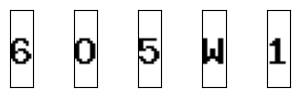

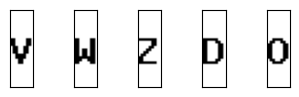

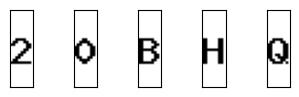

In [6]:
for im in inputs:
    x0= ~(im[:,:,0]<100) #cutoff at pixel value 100
    plt.figure(figsize=(4,1))
    for j in range(5):
        plt.subplot(1,5,j+1)
        plt.imshow(x0[:,5+j*9:5+(j+1)*9], 'gray')
        plt.xticks([]), plt.yticks([])

**The naive segmentation approach seems adequate for these examples**

## 3. Are there any variations in each letter/digit? Conjecture: there is only 1 prototype per character

**We'll use the entire labeled set to verify this**

In [7]:
inputs=[np.array(Image.open('input/input{:02}.jpg'.format(i))) for i in range(25) if i!=21]  #21 is missing output, skip it

def get_output(fname):
    with open(fname,'r') as fp:
        lines=fp.readlines()
    return list(lines[0][:5])
    
outputs=[get_output('output/output{:02}.txt'.format(i)) for i in range(25) if i!=21]

In [8]:
## Group image segments by their class label from outputs
label2examples={}
for im,y in zip(inputs,outputs):
    x0= ~(im[:,:,0]<100)
    for j,label in zip(range(5),y):
        label2examples.setdefault(label,[]).append(x0[:,5+j*9:5+(j+1)*9])

In [9]:
len(label2examples),''.join(sorted(label2examples.keys()))

(36, '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')

**All 36 letters/digits are represented**

In [10]:
for label,li in sorted(label2examples.items()):
    if len(li)>1:
        assert all([ (x==li[0]).all() for x in li[1:]])
        print(label,len(li),'all the same')

0 2 all the same
1 5 all the same
2 5 all the same
3 2 all the same
4 2 all the same
5 3 all the same
6 2 all the same
7 4 all the same
9 4 all the same
A 4 all the same
B 3 all the same
C 4 all the same
D 5 all the same
E 6 all the same
G 5 all the same
H 4 all the same
I 2 all the same
J 3 all the same
K 3 all the same
L 2 all the same
M 5 all the same
O 6 all the same
Q 5 all the same
R 3 all the same
S 4 all the same
T 2 all the same
U 2 all the same
V 6 all the same
W 4 all the same
X 2 all the same
Y 2 all the same
Z 5 all the same


**Indeed there is only one prototype per character**

# Given all 3 conjectures verified, we will use the following simple solution:
### 1. Extract signal from noise with a fixed pixel value threshold
### 2. Segment into image pieces exploiting the fixed locations, size and orientation
### 3. Use a 1-Nearest-Neighbor model to lookup the matching character for each piece

**Since this is a small program, we put everything in one python script (`solution.py`)**

In [11]:
%pycat solution.py

import os
import numpy as np
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier


def extract_signals(im,font_width,col_start,n_char,signal_cutoff):
    """
    Threshold image im by signal_cutoff, cut into pieces specified by the parameters
    font_width, col_start, n_char, signal_cutoff (see class Captcha for parameter descriptions).
    Return:
       list of binary image pieces
    """
    ##we simply take the first channel and apply the cutoff
    x0=np.array( ~(im[:,:,0]<signal_cutoff), dtype='float32' )
    return [x0[:,col_start+j*font_width:col_start+(j+1)*font_width] for j in range(n_char)]


def load_input_output(input_path,output_path):
    """
    Load all jpg images from input_path, find matching output label text file in output_path.
    Only add matching input/output pairs into the returned lists.
    Return (2-tuple):
       list of input images
       list of matching output texts
    """
    inputs=[]
    outputs=[]
    for fname in os.listdir(

### Sanity check: apply the model on the training set and verify the predicted outputs

In [12]:
from solution import Captcha

model=Captcha('input','output')

In [13]:
inputs=[np.array(Image.open('input/input{:02}.jpg'.format(i))) for i in range(25) if i!=21]

for i in range(25):
    model('input/input{:02}.jpg'.format(i),'temp_out.txt')
    out_fname='output/output{:02}.txt'.format(i)
    if os.path.exists(out_fname):
        with open(out_fname,'r') as fp:
            lines=fp.readlines()
        with open('temp_out.txt','r') as fp:
            predicted_lines=fp.readlines()
        assert lines[0]==predicted_lines[0]
        print('Verified',i)

Verified 0
Verified 1
Verified 2
Verified 3
Verified 4
Verified 5
Verified 6
Verified 7
Verified 8
Verified 9
Verified 10
Verified 11
Verified 12
Verified 13
Verified 14
Verified 15
Verified 16
Verified 17
Verified 18
Verified 19
Verified 20
Verified 22
Verified 23
Verified 24


### Generate the final test output

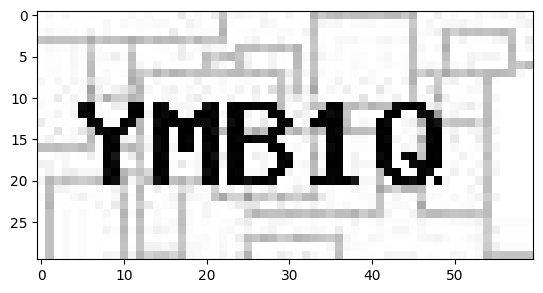

In [14]:
plt.imshow( np.array(Image.open('input/input100.jpg')) )

In [15]:
model('input/input100.jpg','output/output100.txt')

In [16]:
with open('output/output100.txt','r') as fp:
    lines=fp.readlines()
print(lines[0])

YMB1Q

